#0. Clone github repository

In [0]:
!git clone https://github.com/Clem781227/Caterpillar-Tube-Pricing.git

Cloning into 'Caterpillar-Tube-Pricing'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 50 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.


#1. Import libraries

In [0]:
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn import ensemble, preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt

os.chdir('Caterpillar-Tube-Pricing')
print(os.getcwd())

from utils.utils import pred_ints, plot_predictions

/content/Caterpillar-Tube-Pricing


#2. Preprocessing

In [0]:
os.chdir('data')
print(os.getcwd())

/content/Caterpillar-Tube-Pricing/data


##2.0 Import files

In [0]:
dftrain = pd.read_csv('train_set.csv')
tube = pd.read_csv('tube.csv')
bill_of_materials = pd.read_csv('bill_of_materials.csv')

##2.1 Merge datasets

In [0]:
# merge datasets together
dftrain = pd.merge(dftrain, tube, on ='tube_assembly_id')
dftrain = pd.merge(dftrain, bill_of_materials, on ='tube_assembly_id')

# count the number of different options for each variables 
dftrain.agg(['count','nunique'])

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
count,30213,30213,30213,30213,30213,30213,30213,30213,29984,30213,30213,30213,30213,30213,30213,30213,30213,30213,30213,30213,30213,30213,30213,28751,28751,21084,21084,7155,7171,787,787,66,66,28,28,8,8,3,3
nunique,8855,57,1781,761,109,2,119,9380,17,45,29,343,18,74,2,2,2,2,25,24,6,4,8,642,4,452,4,302,4,104,4,29,2,10,2,3,1,1,1


##2.2 Analyse the correlation of variables

In [0]:
numeric_variables = dftrain[['annual_usage','min_order_quantity','quantity','diameter','wall','length','num_bends','bend_radius']]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


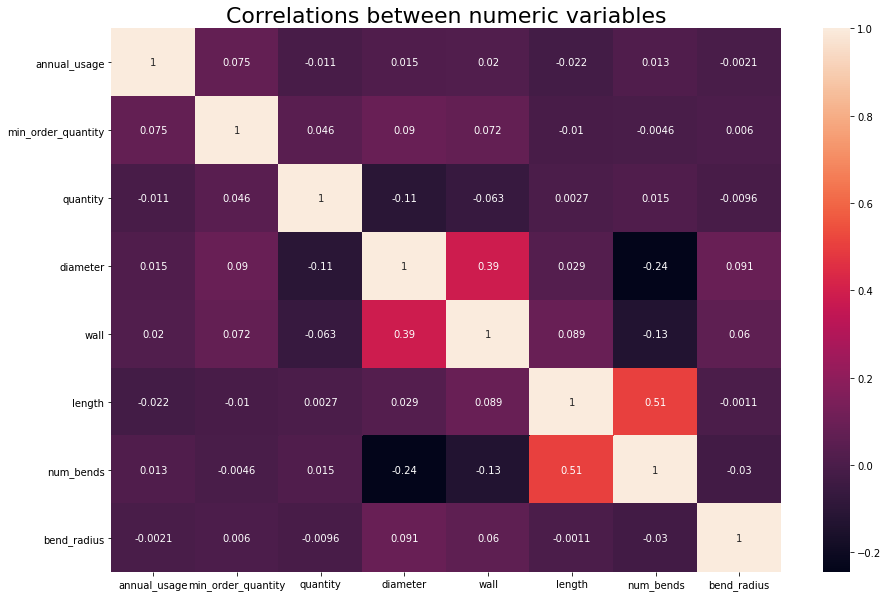

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corrMatrix = numeric_variables.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrMatrix, annot=True)
plt.title('Correlations between numeric variables',fontdict={'size':22})
plt.show()
# Numeric variables are not highly correlated

##2.2 manage unspecified variables

In [0]:
dftrain.isna().sum()

tube_assembly_id          0
supplier                  0
quote_date                0
annual_usage              0
min_order_quantity        0
bracket_pricing           0
quantity                  0
cost                      0
material_id             229
diameter                  0
wall                      0
length                    0
num_bends                 0
bend_radius               0
end_a_1x                  0
end_a_2x                  0
end_x_1x                  0
end_x_2x                  0
end_a                     0
end_x                     0
num_boss                  0
num_bracket               0
other                     0
component_id_1         1462
quantity_1             1462
component_id_2         9129
quantity_2             9129
component_id_3        23058
quantity_3            23042
component_id_4        29426
quantity_4            29426
component_id_5        30147
quantity_5            30147
component_id_6        30185
quantity_6            30185
component_id_7      

In [0]:
dftrain = dftrain.loc[np.invert(dftrain['material_id'].isna())]

In [0]:
# get the log of costs
labels = np.log(dftrain.cost.values.astype('float32'))

# save Tube assembly id
TA_id = dftrain['tube_assembly_id'].values

# drop useless variables
dftrain = dftrain.drop(['quote_date', 'tube_assembly_id','cost'],axis=1)

In [0]:
# replace unspecified variables by a blank space for qualitative variables, 0 otherwise
for i in range(1,9):
    column_label = 'component_id_'+str(i)
    dftrain[column_label].replace(np.nan,' ', regex=True, inplace= True)
dftrain.fillna(0, inplace = True)

##2.4 Manage qualitative variables

In [0]:
# add dummy variables to our dataset
get_dummies = ['supplier','material_id','end_a','end_x']
for variable in get_dummies:
  dftrain = pd.concat([dftrain,pd.get_dummies(dftrain[variable])],axis=1).drop([variable],axis=1)

In [0]:
# head of dataset 
dftrain.head()

,annual_usage,min_order_quantity,bracket_pricing,quantity,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,num_boss,num_bracket,other,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8,S-0003,S-0004,S-0005,S-0006,S-0007,S-0008,S-0009,S-0011,...,EF-010,EF-011,EF-012,EF-013,EF-014,EF-015,EF-016,EF-017,EF-018,EF-019,EF-020,EF-021,EF-022,EF-023,EF-025,NONE,9999,EF-001,EF-002,EF-003,EF-004,EF-005,EF-006,EF-007,EF-008,EF-009,EF-010,EF-011,EF-012,EF-013,EF-014,EF-015,EF-016,EF-017,EF-018,EF-019,EF-021,EF-022,EF-023,NONE
0,0,0,Yes,1,6.35,0.71,137.0,8,19.05,N,N,N,N,0,0,0,C-1312,2.0,,0.0,,0.0,,0.0,,0.0,,0.0,,0.0,,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,Yes,2,6.35,0.71,137.0,8,19.05,N,N,N,N,0,0,0,C-1312,2.0,,0.0,,0.0,,0.0,,0.0,,0.0,,0.0,,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,Yes,5,6.35,0.71,137.0,8,19.05,N,N,N,N,0,0,0,C-1312,2.0,,0.0,,0.0,,0.0,,0.0,,0.0,,0.0,,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,Yes,10,6.35,0.71,137.0,8,19.05,N,N,N,N,0,0,0,C-1312,2.0,,0.0,,0.0,,0.0,,0.0,,0.0,,0.0,,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,Yes,25,6.35,0.71,137.0,8,19.05,N,N,N,N,0,0,0,C-1312,2.0,,0.0,,0.0,,0.0,,0.0,,0.0,,0.0,,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# extract data from pandas dataframe
train = dftrain.values

In [0]:
# label encode the categorical variables
for i in range(train.shape[1]):
      #if i in [0,3,5,11,12,13,14,15,16,20,22,24,26,28,30,32,34]:
      if i in [0,2,9,10,11,12,16,18,20,22,24,26,28,30]:
        label_encoder = preprocessing.LabelEncoder()
        label_encoder.fit(list(train[:,i]))
        train[:,i] = label_encoder.transform(train[:,i])

##2.5 Divide our dataset into train and test sets

In [0]:
dico_id = {}
for k,id in enumerate(TA_id):
  dico_id[id] = dico_id.get(id,[]) + [k]

all_ids = np.array(list(dico_id.keys()))

mask = np.random.choice(2,size=len(all_ids),p=[0.8,0.2]).astype(bool)

In [0]:
train = train.astype('float32')
X_test = []
y_test = []
X_train = []
y_train = []

test_ids = all_ids[mask]

for id in all_ids:
  if id in test_ids:
    for k in dico_id[id]:
      X_test += [train[k]]
      y_test += [labels[k]]
  else:
    for k in dico_id[id]:
      X_train += [train[k]]
      y_train += [labels[k]]

X_test = np.array(X_test)
y_test = np.array(y_test)
X_train = np.array(X_train)
y_train = np.array(y_train)

## 2.6 Detect outliers

In [0]:
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
  eps = 3,
  metric="euclidean",
  min_samples = 3,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(X_train[:,4:7])

In [0]:
not_outliers = clusters!=-1
print('there are ',len(clusters[clusters==-1]),' outliers')

there are  260  outliers


In [0]:
#Remove outliers doesn't improve results so we keep them
#X_train = X_train[not_outliers]
#y_train = y_train[not_outliers]

In [0]:
print('training set has shape : ',X_train.shape)

training set has shape :  (24207, 155)


#3. Pricing tool


##3.0 Benchmark with linear regression and decision tree regressor

### 3.0.1 Linear regression

In [0]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()
lreg.fit(X_train,y_train)

pred_train_lreg = lreg.predict(X_train)
pred_test_lreg = lreg.predict(X_test)

print('Root mean squared log error on train set : ',np.sqrt(np.mean((pred_train_lreg-y_train)**2)))
print('Root mean squared log error on test set : ',np.sqrt(np.mean((pred_test_lreg-y_test)**2)))

Root mean squared log error on train set :  0.66726214
Root mean squared log error on test set :  0.6880228


### 3.0.2 Decision tree regressor

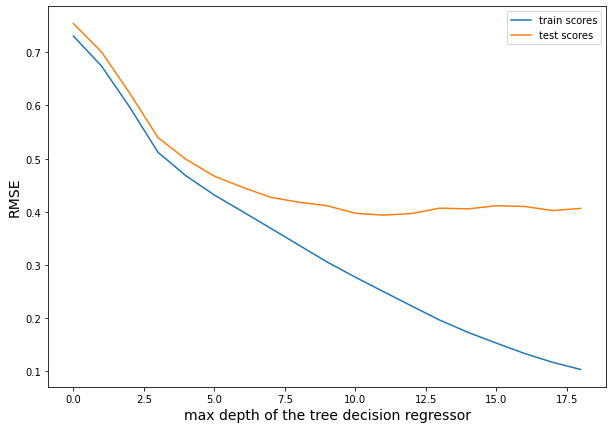

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

score_train = []
score_test = []

# We try different max_depth to find the best parameter

for k in range(1,20):

  dtr = DecisionTreeRegressor(max_depth=k,splitter='best')
  dtr.fit(X_train,y_train)

  pred_train = dtr.predict(X_train)
  pred_test = dtr.predict(X_test)

  score_train += [np.sqrt(np.mean((pred_train-y_train)**2))]
  score_test += [np.sqrt(np.mean((pred_test-y_test)**2))]

plt.figure(figsize=(10,7))
plt.plot(score_train,label='train scores')
plt.plot(score_test,label='test scores')
plt.xlabel('max depth of the tree decision regressor',fontdict={'size':14})
plt.ylabel('RMSE',fontdict={'size':14})
plt.legend()
plt.show()

In [0]:
best_param = np.argmin(score_test)
dtr = DecisionTreeRegressor(max_depth=best_param)
dtr.fit(X_train,y_train)

pred_train_dtr = dtr.predict(X_train)
pred_test_dtr = dtr.predict(X_test)

print('Root mean squared log error on train set : ',np.sqrt(np.mean((pred_train_dtr-y_train)**2)))
print('Root mean squared log error on test set : ',np.sqrt(np.mean((pred_test_dtr-y_test)**2)))

Root mean squared log error on train set :  0.27700804791954303
Root mean squared log error on test set :  0.4023402708351205


##3.1 Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [0]:
RF = RandomForestRegressor(n_estimators=100,max_depth=15)
RF.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
pred_train_rf = RF.predict(X_train)
pred_test_rf = RF.predict(X_test)

print('Root mean squared log error on train set : ',np.sqrt(np.mean((pred_train_rf-y_train)**2)))
print('Root mean squared log error on test set : ',np.sqrt(np.mean((pred_test_rf-y_test)**2)))

Root mean squared log error on train set :  0.16035340736523543
Root mean squared log error on test set :  0.3174275892644154


In [0]:
pourcent_train, _, _ = pred_ints(RF, X_train, y_train, percentile=95)
pourcent_test , err_down, err_up = pred_ints(RF, X_test, y_test, percentile=95)

print(round(100*pourcent_train,1),'% of predictions in training set are in 95% confidence range')
print(round(100*pourcent_test,1),'% of predictions in testing set are in 95% confidence range')

89.4 % of predictions in training set are in 95% confidence range
81.0 % of predictions in testing set are in 95% confidence range


##3.3 XGBoost

In [0]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [0]:
# If we have time and computational power we can use grid_search to find best parameters
parameters_for_testing = {
    'eta':[0.02],
    'min_child_weight':[4],
    'subsample':[0.7],
    'max_depth':[8],
    'n_estimators':[100],
    'colsample_bytree':[0.6],
    'scale_pos_weight':[0.8], 
    'silent':[1],
    'max_delta_step':[2]
}
                    
xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=42)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   55.5s remaining:  1.4min
[Parallel(n_jobs=6)]: Done   3 out of   5 | elapsed:   55.7s remaining:   37.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   55.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   55.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=1000, n_jobs=1, nthread=6,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, r...
                                    scale_pos_weight=1, seed=42, silent=None,
                                    subsample=0.8, verbosity=1),
             iid=False, n_jobs=6,
             param_grid={'colsample_bytree': [0.6], 'eta': [0.02],
                         'max_delta_step': [2], 'max_depth': [8],
               

In [0]:
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best params
{'colsample_bytree': 0.6, 'eta': 0.02, 'max_delta_step': 2, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 100, 'scale_pos_weight': 0.8, 'silent': 1, 'subsample': 0.7}
best score
-0.10407018363475799


In [0]:
# Set the parameters of XGBoost
params = {}
params["objective"] = "reg:linear"
params["eta"] = 0.02
params["min_child_weight"] = 4
params["subsample"] = 0.7
params["colsample_bytree"] = 0.6
params["scale_pos_weight"] = 0.8
params["silent"] = 1
params["max_depth"] = 8
params["max_delta_step"]=2

In [0]:
parameters = list(params.items())

xgtrain = xgb.DMatrix(X_train, label=y_train)
xgtest = xgb.DMatrix(X_test, label=y_test)

num_rounds = 1000
xgb_model = xgb.train(parameters, xgtrain, num_rounds)

In [0]:
pred_test_xgb = xgb_model.predict(xgtest)
pred_train_xgb = xgb_model.predict(xgtrain)

print('Root mean squared log error on train set : ',np.sqrt(np.mean((pred_train_xgb-y_train)**2)))
print('Root mean squared log error on test set : ',np.sqrt(np.mean((pred_test_xgb-y_test)**2)))

Root mean squared log error on train set :  0.15021685
Root mean squared log error on test set :  0.27035743


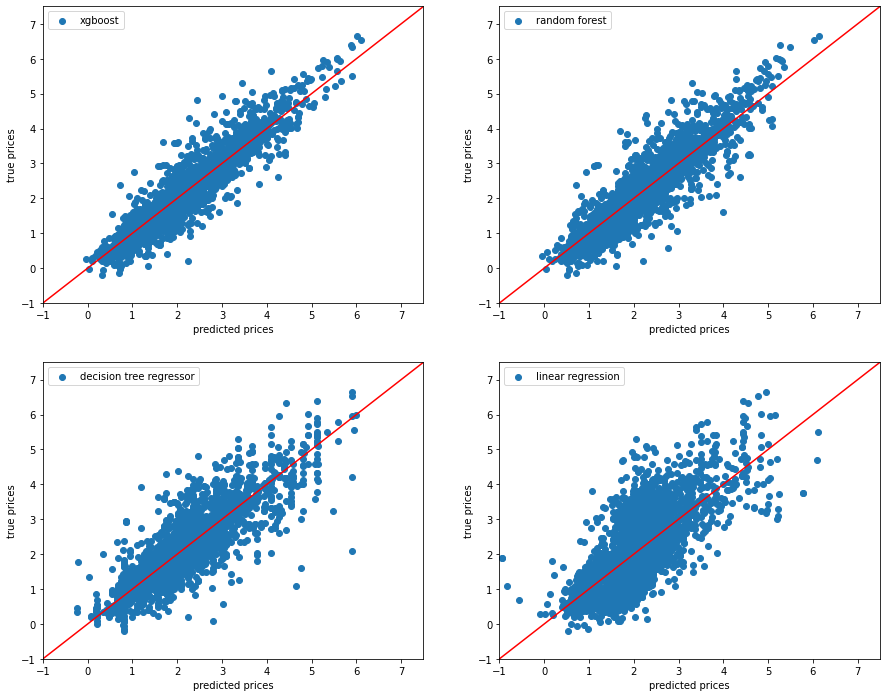

In [0]:
plot_predictions(pred_test_xgb, pred_test_rf, pred_test_dtr, pred_test_lreg, y_test)

To get confidence range for XGBoost, refer to : https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b

#4. reduce the cost of a public works project

##4.1 Choosing the material

Here we study the variation of the price according to the material

In [0]:
dftrain.columns[89:89+17]

Index(['SP-0008', 'SP-0019', 'SP-0028', 'SP-0029', 'SP-0030', 'SP-0031',
       'SP-0032', 'SP-0033', 'SP-0034', 'SP-0035', 'SP-0036', 'SP-0037',
       'SP-0038', 'SP-0039', 'SP-0041', 'SP-0046', 'SP-0048'],
      dtype='object')

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
No handles with labels found to put in legend.


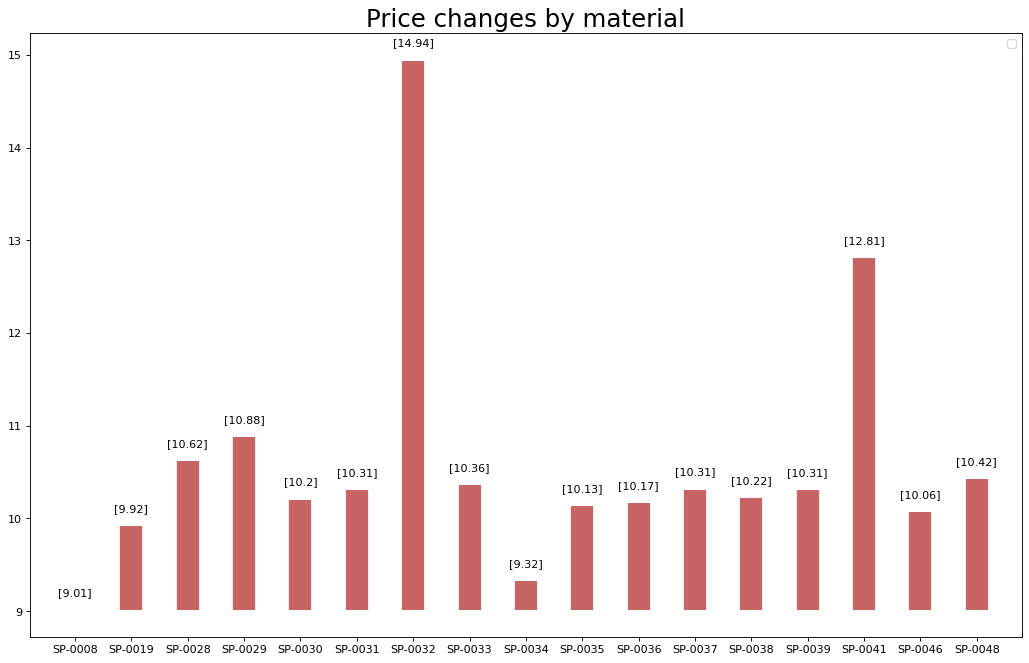

In [0]:
data = np.copy(X_test[100:101])
prices = []
for k in range(17):
  data[0,89:106] = np.zeros(17)
  data[0,89+k] = 1
  prices += [xgb_model.predict(xgb.DMatrix(data))]

prices = np.exp(np.array(prices))
fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
ax.vlines(x=dftrain.columns[89:89+17], ymin=min(prices), ymax=prices, color='firebrick', alpha=0.7, linewidth=20)
m = np.mean(prices)-np.min(prices)
for i, price in enumerate(prices):
    ax.text(i, price+0.1*m, np.round(price, 2), horizontalalignment='center')
plt.title('Price changes by material',fontdict={'size':22})
plt.legend()
plt.show()

##4.2 Reduce dimensions of the tube 

In this part we study the possibility of reducing dimensions of tubes to reduce their price

In [0]:
data = np.copy(X_test[0:1])
wall = data[0,6]

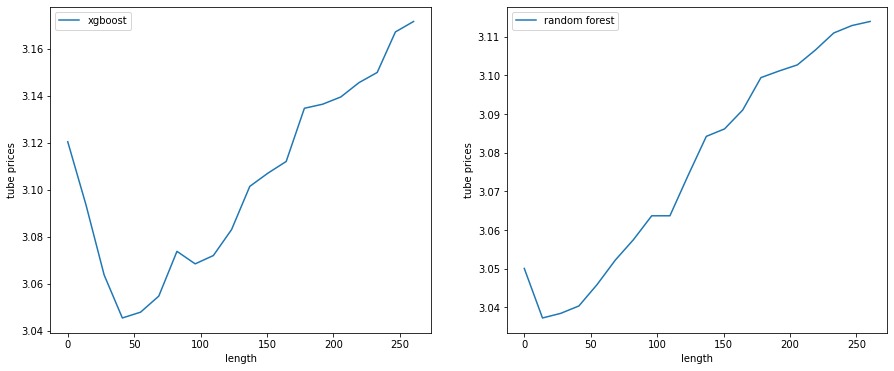

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

data = np.copy(X_test[:1])
wall = data[0,6]
prices = []
walls = []
for k in range(20):
  data[0,6] = k*0.1*wall
  walls += [k*0.1*wall]
  prices += [xgb_model.predict(xgb.DMatrix(data))]

axs[0].plot(walls, prices, label='xgboost')
axs[0].legend()
axs[0].set_xlabel('length')
axs[0].set_ylabel('tube prices')

data = np.copy(X_test[:1])
wall = data[0,6]
prices = []
walls = []
for k in range(20):
  data[0,6] = k*0.1*wall
  walls += [k*0.1*wall]
  prices += [RF.predict(data)]

axs[1].plot(walls, prices, label='random forest')
axs[1].legend()
axs[1].set_xlabel('length')
axs[1].set_ylabel('tube prices')

plt.show()